# Support points with Exponential Mechanism

### Procedure:


1. Given data $X = \{x_1, \ldots, x_M\}$ on space $\mathcal{D} \in [0, 1]^d$, find optimal support points $Y = \{y_1, \ldots, y_N\}$.
2. Using energy distance (with Lp norm) as the score function of the exponential mechanism, the sensitivity is $\Delta f = \frac{2 d^{1/p}(2N - 1)}{N^2}$. The exponential mechanism samples a new energy value $\tilde{e} \sim \mbox{Exp}(\frac{2\Delta f}{\alpha})$, where $\alpha$ is the privacy budget.
3. Let $\tilde{Y}$ be a copy of $Y$. While $e(\tilde{Y}, Y) < \tilde{e}$, perturb all points in $\tilde{Y}$ with small step in a random direction.

---

 
Note: Exponential samples (i.e. energy distances) are larger with:
  - small privacy budget, $\alpha$
  - large sensitivity, $\Delta f$
  - large dimensionality, $d$
  - small energy exponent, $p$
  - small support point set, $N$.

___

# 0. Helper Functions

In [1]:
%matplotlib inline

import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pdb
from scipy.spatial.distance import pdist
import sys
import tensorflow as tf
import time

from data import load_balog_data
from sp_utils import (
    get_support_points,
    energy,
    sample_sp_exp_mech,
    mixture_model_likelihood,
    sample_full_set_by_diffusion)

matplotlib.rcParams.update({'font.size': 14})
plt.style.use('ggplot')
print(sys.version)
print(tf.__version__)

3.7.1 (default, Nov 28 2018, 11:55:14) 
[Clang 9.0.0 (clang-900.0.39.2)]
1.13.1


In [2]:
np.random.seed(123)

____

# 1. Global Config

Note: Exponential samples (i.e. energy distances) are smaller with:
  - large privacy budget, $\alpha$
  - small sensitivity, $\Delta f$
  - small dimensionality, $d$
  - large energy exponent, $p$
  - large support point set, $N$

In [3]:
# Set global constants.          # main1()
IS_TF = True                     # Boolean. Use TensorFlow rather than analytical gradients.
Y_INIT_OPTION = 'radial'         # ['grid', 'random', 'radial']
MAX_ITER = 601                   # Num iterations in each support point optimization. [301]
LR = 1e-2                        # Energy optimization learning rate. [1e-2]

M = 200                          # Number of data points.
DIM = 2                          # Dimension of data.
C = 10                           # Number of clusters in data.
SIGMA_DATA = 0.03                # Bandwidth of data.

ENERGY_POWER = 2.                # Power for energy distance kernel.
ALPHA = 50                       # Differential privacy level.
N = 20                           # Number of support points.
STEP_SIZE = 1e-3                 # Diffusion and MH step sizes.
NUM_Y_TILDES = 500               # Number of samples of support points.

___

# 2. Load and Plot Data

In [4]:
# Load data.
x = load_balog_data(M, DIM, C, SIGMA_DATA, make_new=True, do_weighted=True)

Loaded M=200, DIM=2, SIG=0.03, C=10


___

# 3. Run Support Point Optimization

is_tf: True, y_init: radial, clip: bounds, wlb: False

  [*] Using TensorFlow optimization.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
  [*] Overall it/s: 0.0042


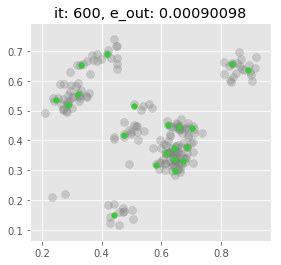

Time elapsed: 2.738295078277588


In [5]:
# Compute m support points on full set.
y_opt, e_opt = get_support_points(x, N, MAX_ITER, LR, is_tf=IS_TF)

#### Paper: Figure of support point optimization for variety of cluster sizes and counts.

Loaded M=200, DIM=2, SIG=0.02, C=5
is_tf: True, y_init: radial, clip: bounds, wlb: False

  [*] Using TensorFlow optimization.
Time elapsed: 3.735517978668213
Loaded M=200, DIM=2, SIG=0.02, C=10
is_tf: True, y_init: radial, clip: bounds, wlb: False

  [*] Using TensorFlow optimization.
Time elapsed: 2.7714240550994873
Loaded M=200, DIM=2, SIG=0.02, C=30
is_tf: True, y_init: radial, clip: bounds, wlb: False

  [*] Using TensorFlow optimization.
Time elapsed: 2.464272975921631
Loaded M=200, DIM=2, SIG=0.04, C=5
is_tf: True, y_init: radial, clip: bounds, wlb: False

  [*] Using TensorFlow optimization.
Time elapsed: 3.5606472492218018
Loaded M=200, DIM=2, SIG=0.04, C=10
is_tf: True, y_init: radial, clip: bounds, wlb: False

  [*] Using TensorFlow optimization.
Time elapsed: 2.474843740463257
Loaded M=200, DIM=2, SIG=0.04, C=30
is_tf: True, y_init: radial, clip: bounds, wlb: False

  [*] Using TensorFlow optimization.
Time elapsed: 2.4941539764404297


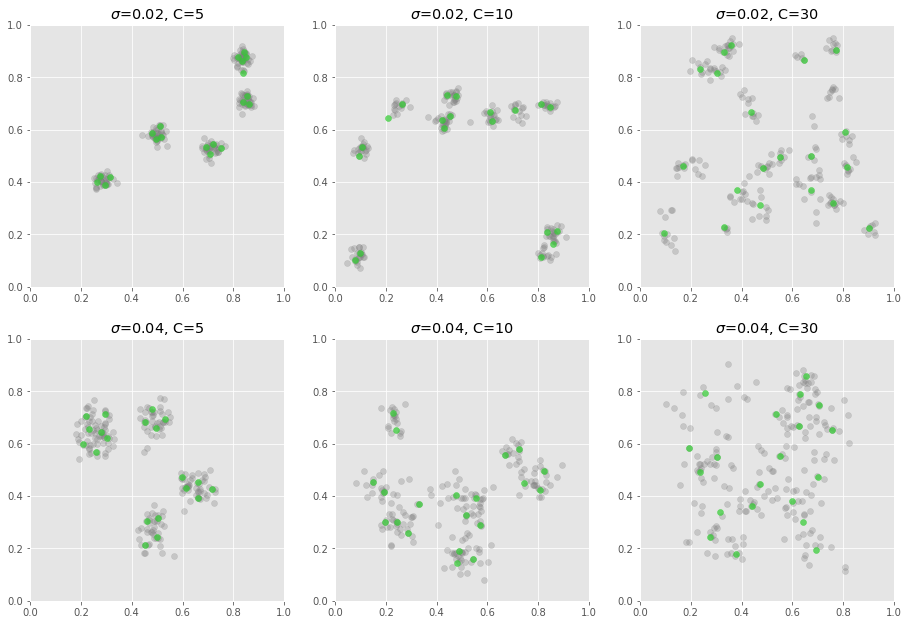

In [6]:
example_sigmas = [0.02, 0.04]
example_clusters = [5, 10, 30]
n_sig = len(example_sigmas)
n_clu = len(example_clusters)

fig, axs = plt.subplots(n_sig, n_clu, figsize=(5 * n_clu, 5 * n_sig))
for i, sigma in enumerate(example_sigmas):
    for j, cluster_count in enumerate(example_clusters):
        temp_data = load_balog_data(M, DIM, cluster_count, sigma, make_new=True,
                                    do_weighted=False)
        temp_y_opt, temp_e_opt = get_support_points(temp_data, N, MAX_ITER,
                                                    LR, is_tf=IS_TF, plot=False)

        axs[i, j].set_title('$\sigma$={}, C={}'.format(sigma, cluster_count))
        axs[i, j].scatter(temp_data[:, 0], temp_data[:, 1], c='gray', alpha=0.3)
        axs[i, j].scatter(temp_y_opt[:, 0], temp_y_opt[:, 1], c='limegreen', alpha=0.7)
        axs[i, j].set_xlim((0, 1))
        axs[i, j].set_ylim((0, 1))


plt.subplots_adjust(wspace=0.2, hspace=0.2,
                    bottom=0.1, top=0.9, left=0.1, right=0.9)
plt.savefig('../output/fig_sp_optimization.png')

___

# 4. Define sensitivity.

In [7]:
# Define energy sensitivity for Exponential Mechanism.
# OLD: energy_sensitivity = 2 * DIM ** (1. / ENERGY_POWER) / N ** 2
energy_sensitivity = 2 * DIM ** (1. / ENERGY_POWER) * (2 * N - 1) / N ** 2
print(('Exp(2 * U / alpha) = Exp(2 * {:.4f} / {:.2f}) '
       '= Exp({:.3f})').format(energy_sensitivity, ALPHA, 
                               2. * energy_sensitivity / ALPHA))

Exp(2 * U / alpha) = Exp(2 * 0.2758 / 50.00) = Exp(0.011)


___

# 5. Sample support points.

In [8]:
RUN_MH = 1
RUN_DIFFUSION = 1
PLOT = 1



--------- RUNNING MH ----------


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 10000.000) = Exp(0.0001)

Running chain. Length=21000, Burn=1000, Thin=200, Step=0.001
Difference factor: 18130.94


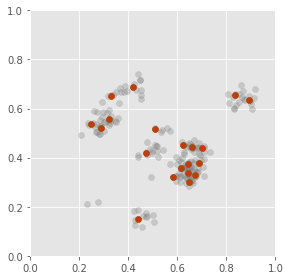

Acceptance rate: 0.0
Energy diff: -0.00013745


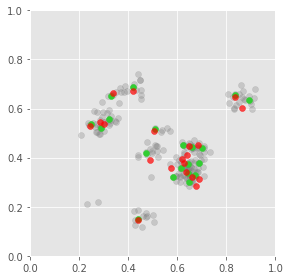

Acceptance rate: 0.7226386806596702
Energy diff: -0.00003190


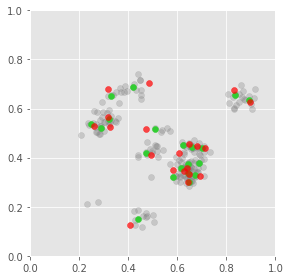

Acceptance rate: 0.7215696075981005
Energy diff: -0.00002969


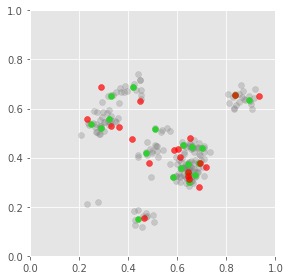

Acceptance rate: 0.7312114647558741
Energy diff: 0.00006126


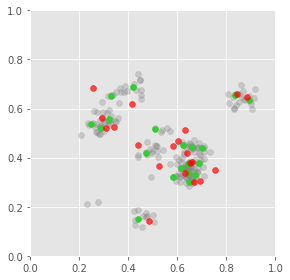

Acceptance rate: 0.72928383952006
Energy diff: 0.00002501


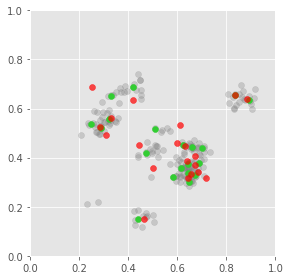

Acceptance rate: 0.7297270272972702
Energy diff: 0.00001423


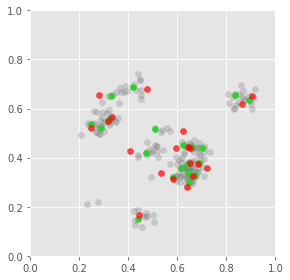

Acceptance rate: 0.7306057828514291
Energy diff: -0.00005746


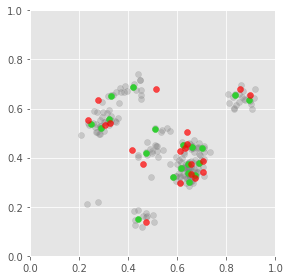

Acceptance rate: 0.7310906363831154
Energy diff: -0.00001222


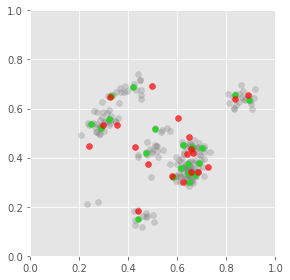

Acceptance rate: 0.7326417098931317
Energy diff: 0.00000882


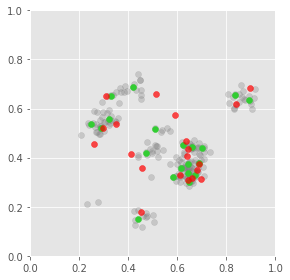

Acceptance rate: 0.73129270596078
Energy diff: -0.00002055


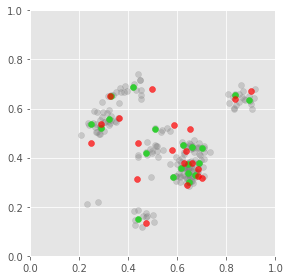

Acceptance rate: 0.7324633768311585
Energy diff: 0.00000124


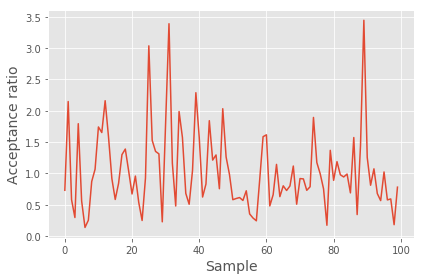

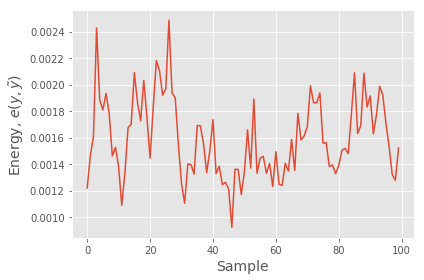

Acceptance ratio: 0.7318571428571429
percent steps that improved energy score: 0.36238095238095236


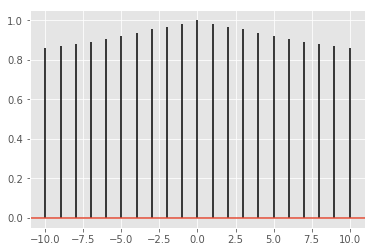

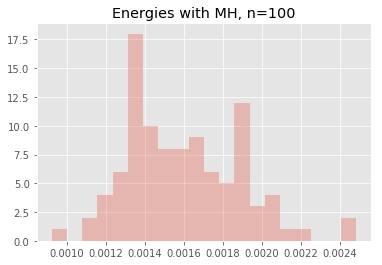

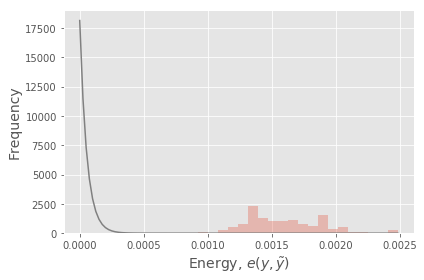

p: 5.515432893255071e-05


In [9]:
if RUN_MH:
    # Sampling parameters.
    STEP_SIZE = 1e-3
    NUM_Y_TILDES = 100
    ALPHA_MH = 10000

    METHOD = 'mh'
    print('\n\n--------- RUNNING {} ----------\n'.format(METHOD.upper()))
    (y_tildes_mh,
     energies_mh,
     _) = sample_sp_exp_mech(e_opt, energy_sensitivity, x, y_opt,
                             METHOD, STEP_SIZE, NUM_Y_TILDES, ALPHA_MH,
                             plot=PLOT)
    
    if PLOT:
        #plt.title('Energies with MH, {} samples'.format(len(energies_mh)))
        plt.hist(energies_mh, bins=20, alpha=0.3, density=True, label='Samples')
        
        
        # Compare to Exponential density.
        p = exponential_param = 2. * energy_sensitivity / ALPHA_MH
        xs = np.linspace(0, np.max(energies_mh), 100)
        xs_dens = 1 / p * np.exp(-xs / p)
        plt.plot(xs, xs_dens, c='gray', label='Exponential density')
        plt.xlabel(r'Energy, $e(y, \tilde{y})$', fontsize=14)
        plt.ylabel('Frequency', fontsize=14)

        plt.tight_layout()
        plt.savefig('../output/fig_mh_energies.png')
        plt.show()
        print('p: {}'.format(p))



--------- RUNNING DIFFUSION ----------


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 50.000) = Exp(0.0110)


Exp. mean: 0.01103, e_tilde: 0.01933
  step_size_factor: 0.87622, adjusted: 0.01 -> 0.00876
  Diffusion count    85, e_opt:  0.000901, (e(y, y~) - e~) / e~ = error%: (0.02025 - 0.01933) / 0.01933 = 0.04757

Exp. mean: 0.01103, e_tilde: 0.01209
  step_size_factor: 0.54802, adjusted: 0.01 -> 0.00548
  Diffusion count   142, e_opt:  0.000901, (e(y, y~) - e~) / e~ = error%: (0.01211 - 0.01209) / 0.01209 = 0.00123

Exp. mean: 0.01103, e_tilde: 0.00554
  step_size_factor: 0.50207, adjusted: 0.01 -> 0.00502
  Diffusion count    46, e_opt:  0.000901, (e(y, y~) - e~) / e~ = error%: (0.00562 - 0.00554) / 0.00554 = 0.01474

Exp. mean: 0.01103, e_tilde: 0.02119
  step_size_factor: 0.96047, adjusted: 0.01 -> 0.00960
  Diffusion count   118, e_opt:  0.000901, (e(y, y~) - e~) / e~ = error%: (0.02160 - 0.02119) / 0.02119 = 0.01917

Exp. mean: 0.01103, e_tilde: 0.0476

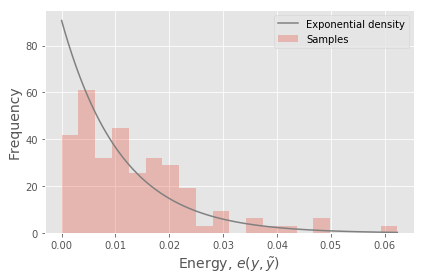

p: 0.011030865786510143


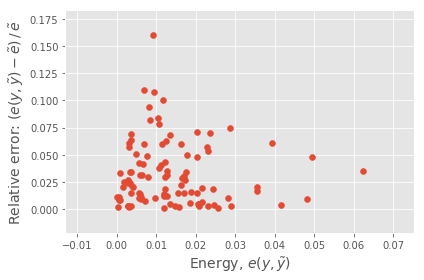

In [10]:
if RUN_DIFFUSION:
    # Sampling parameters.
    STEP_SIZE = 1e-2
    NUM_Y_TILDES = 100
    # ALPHA = 100
    
    METHOD = 'diffusion'
    print('\n\n--------- RUNNING {} ----------\n'.format(METHOD.upper()))
    (y_tildes_diffusion,
     energies_diffusion,
     energy_estimation_errors_diffusion) = sample_sp_exp_mech(e_opt,
                                                              energy_sensitivity,
                                                              x, y_opt, METHOD,
                                                              STEP_SIZE, NUM_Y_TILDES,
                                                              ALPHA)
    
    if PLOT:
        #plt.title('Energies with Diffusion, {} samples'.format(len(energies_diffusion)))
        plt.hist(energies_diffusion, bins=20, alpha=0.3, density=True, label='Samples')
        plt.xlabel(r'Energy, $e(y, \tilde{y})$', fontsize=14)
        plt.ylabel('Frequency', fontsize=14)
        
        # Compare to Exponential density.
        p = exponential_param = 2. * energy_sensitivity / ALPHA
        xs = np.linspace(0, np.max(energies_diffusion), 100)
        xs_dens = 1 / p * np.exp(-xs / p)
        plt.plot(xs, xs_dens, c='gray', label='Exponential density')
        plt.legend()
        plt.tight_layout()
        plt.savefig('../output/fig_diffusion_energies.png')
        plt.show()
        print('p: {}'.format(p))
        
        # Scatter plot the errors.
        errs = energy_estimation_errors_diffusion
        plt.scatter(errs[:, 0], errs[:, 1])
        plt.xlabel(r'Energy, $e(y, \tilde{y})$', fontsize=14)
        plt.ylabel(r'Relative error: $(e(y, \tilde{y}) - \tilde{e}) \, / \, \tilde{e}$',
                   fontsize=14)
        plt.tight_layout()
        plt.savefig('../output/fig_diffusion_energy_errors.png')
        plt.show()


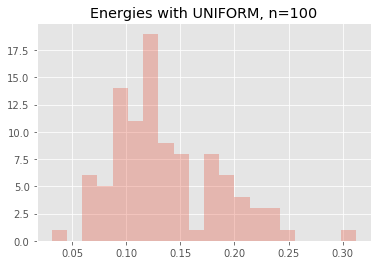

In [11]:
# Compare to energies of e(y_opt, uniform)
baseline_energies = np.zeros(NUM_Y_TILDES)
for i in range(NUM_Y_TILDES):
    e_, _ = energy(y_opt, np.random.uniform(size=y_opt.shape))
    baseline_energies[i] = e_
plt.title('Energies with UNIFORM, n={}'.format(len(baseline_energies)))
plt.hist(baseline_energies, bins=20, alpha=0.3)
plt.show()

#### Paper: Figure of private support point samples with various alphas.


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 1.000) = Exp(0.5515)

Using diffusion mean:

Exp. mean: 0.55154, e_tilde: 0.55154
  step_size_factor: 1.00000, adjusted: 0.25 -> 0.25000
  Diffusion count 10913, e_opt:  0.000901, (e(y, y~) - e~) / e~ = error%: (0.58359 - 0.55154) / 0.55154 = 0.05811

Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 10.000) = Exp(0.0552)

Using diffusion mean:

Exp. mean: 0.05515, e_tilde: 0.05515
  step_size_factor: 1.00000, adjusted: 0.01 -> 0.01000
  Diffusion count   305, e_opt:  0.000901, (e(y, y~) - e~) / e~ = error%: (0.05677 - 0.05515) / 0.05515 = 0.02926

Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 100.000) = Exp(0.0055)

Using diffusion mean:

Exp. mean: 0.00552, e_tilde: 0.00552
  step_size_factor: 1.00000, adjusted: 0.01 -> 0.01000
  Diffusion count     9, e_opt:  0.000901, (e(y, y~) - e~) / e~ = error%: (0.00583 - 0.00552) / 0.00552 = 0.05744

Pr(e) ~ Exp(2U/a) = a / (2U) *

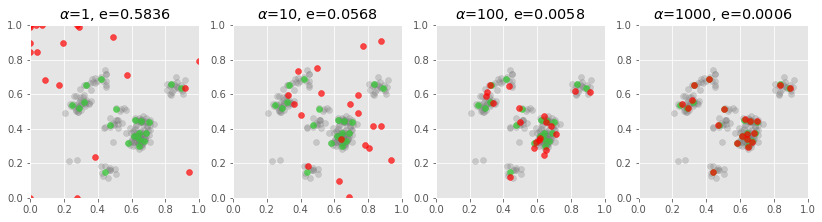

In [12]:
example_alphas = [1, 10, 100, 1000]
step_sizes = [0.25, 1e-2, 1e-2, 1e-3]
n_alp = len(example_alphas)
fig, axs = plt.subplots(1, n_alp, figsize=(3 * n_alp, 3))
for i, alpha in enumerate(example_alphas):
    np.random.seed(123)
    (y_tildes_diffusion,
     energies_diffusion,
     energy_errors_diffusion) = sample_sp_exp_mech(e_opt, energy_sensitivity,
                                                   x, y_opt, 'diffusion',
                                                   step_size=step_sizes[i],
                                                   num_y_tildes=1,
                                                   alpha=alpha,
                                                   diffusion_mean=True)

    axs[i].set_title(r'$\alpha$={}, e={:.4f}'.format(alpha,
                                                     energies_diffusion[0]))
    axs[i].scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3)
    axs[i].scatter(y_opt[:, 0], y_opt[:, 1], c='limegreen', alpha=0.7)
    axs[i].scatter(y_tildes_diffusion[0, :, 0],
                   y_tildes_diffusion[0, :, 1],
                   c='red', alpha=0.7)
    axs[i].set_xlim((0, 1))
    axs[i].set_ylim((0, 1))
        
plt.subplots_adjust(wspace=0.2, hspace=0.2,
                    bottom=0.1, top=0.9, left=0.05, right=0.95)
plt.savefig('../output/fig_sp_different_alphas.png')
plt.show()

___

# 6. Expand to full data set.

## 6.0 KDE with pre-selected bandwidth.

#### Given privately sampled (by diffusion) SP, expand them using KDE and pre-selected bandwidth.


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 50.000) = Exp(0.0110)


Exp. mean: 0.01103, e_tilde: 0.00035
  step_size_factor: 0.03146, adjusted: 0.01 -> 0.00031
  Diffusion count    63, e_opt:  0.000901, (e(y, y~) - e~) / e~ = error%: (0.00035 - 0.00035) / 0.00035 = 0.01261

Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 50.000) = Exp(0.0110)


Exp. mean: 0.01103, e_tilde: 0.00035
  step_size_factor: 0.03146, adjusted: 0.01 -> 0.00031
  Diffusion count    63, e_opt:  0.000901, (e(y, y~) - e~) / e~ = error%: (0.00035 - 0.00035) / 0.00035 = 0.01261

Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 50.000) = Exp(0.0110)


Exp. mean: 0.01103, e_tilde: 0.00035
  step_size_factor: 0.03146, adjusted: 0.01 -> 0.00031
  Diffusion count    63, e_opt:  0.000901, (e(y, y~) - e~) / e~ = error%: (0.00035 - 0.00035) / 0.00035 = 0.01261


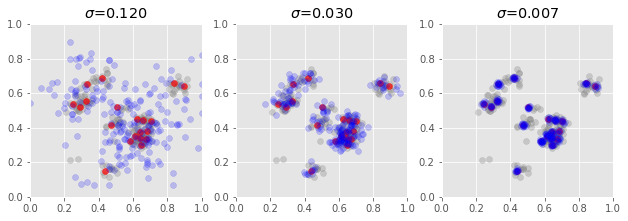

In [13]:
# Show data and y_tilde.
NUM_Y_TILDES = 1
METHOD = 'diffusion'
FULL_SAMPLE_SIZE = M
STEP_SIZE = 1e-2
PLOT = 1

bandwidths = [SIGMA_DATA * 4, SIGMA_DATA, SIGMA_DATA / 4]
n_bw = len(bandwidths)

fig, axs = plt.subplots(1, n_bw, figsize=(3 * n_bw, 3))

for i, bw in enumerate(bandwidths):
    np.random.seed(234)
    (y_tilde,
     y_tilde_upsampled,
     y_tilde_expansion) = sample_full_set_by_diffusion(e_opt, energy_sensitivity,
                                                       x, y_opt, STEP_SIZE, ALPHA,
                                                       bw, FULL_SAMPLE_SIZE, 
                                                       plot=False)

    axs[i].set_title(r'$\sigma$={:.3f}'.format(bw))
    axs[i].scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3)
    axs[i].scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=0.7)
    axs[i].scatter(y_tilde_expansion[:, 0], y_tilde_expansion[:, 1],
                   c='blue', alpha=0.2)
    axs[i].set_xlim((0, 1))
    axs[i].set_ylim((0, 1))
        
plt.subplots_adjust(wspace=0.2, hspace=0.2,
                    bottom=0.1, top=0.9, left=0.05, right=0.95)
plt.savefig('../output/fig_kde_fixed_bandwidth.png')

## 6.1 KDE with DP-MLE bandwidth.

#### Compute likelihood over a range of bandwidths, and compute likelihood for each.


-----------------------------



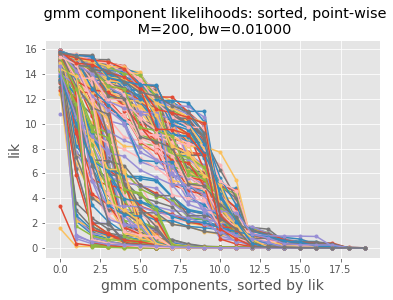

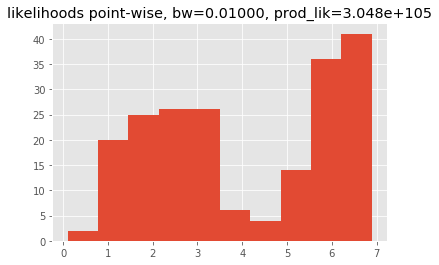

	 prod_liks=3.048e+105,
	 log_prod_liks=2.429e+02,
	 sum_lliks=2.429e+02



-----------------------------



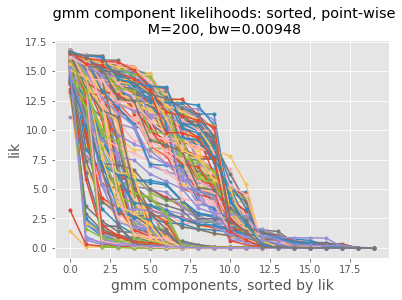

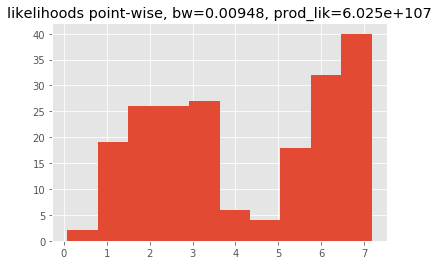

	 prod_liks=6.025e+107,
	 log_prod_liks=2.482e+02,
	 sum_lliks=2.482e+02



-----------------------------



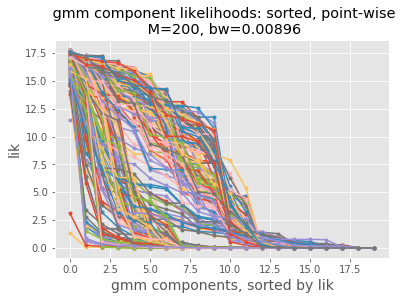

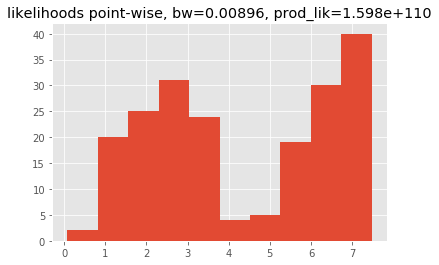

	 prod_liks=1.598e+110,
	 log_prod_liks=2.538e+02,
	 sum_lliks=2.538e+02



-----------------------------



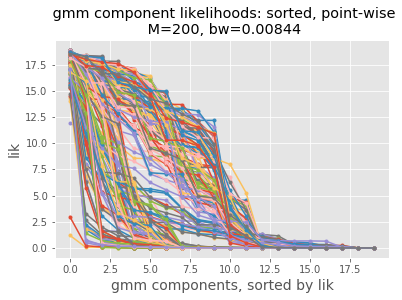

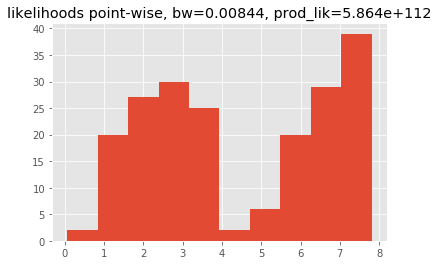

	 prod_liks=5.864e+112,
	 log_prod_liks=2.597e+02,
	 sum_lliks=2.597e+02



-----------------------------



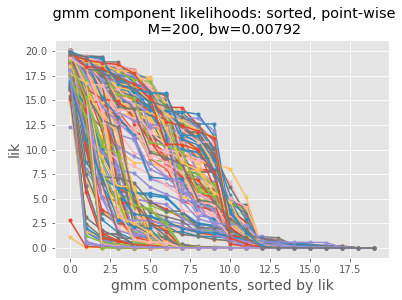

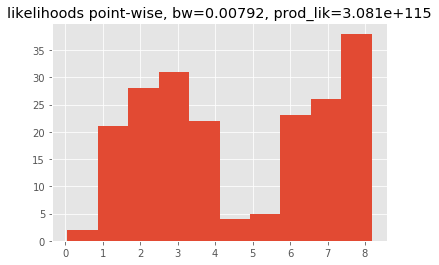

	 prod_liks=3.081e+115,
	 log_prod_liks=2.659e+02,
	 sum_lliks=2.659e+02



-----------------------------



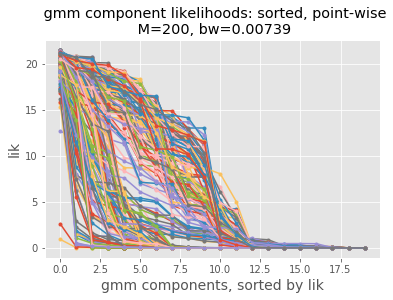

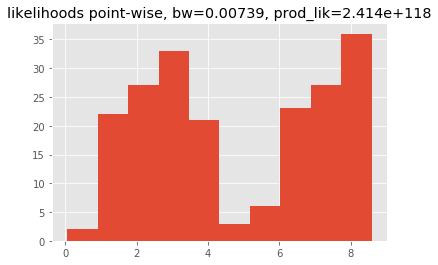

	 prod_liks=2.414e+118,
	 log_prod_liks=2.726e+02,
	 sum_lliks=2.726e+02



-----------------------------



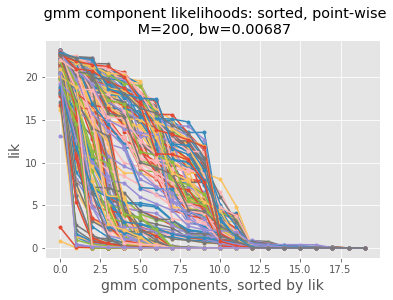

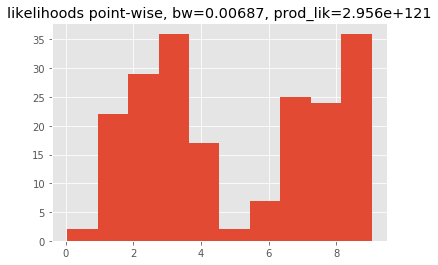

	 prod_liks=2.956e+121,
	 log_prod_liks=2.797e+02,
	 sum_lliks=2.797e+02



-----------------------------



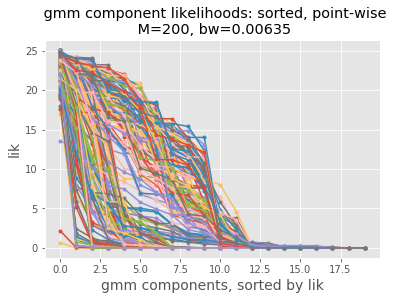

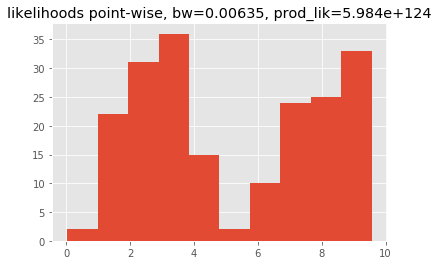

	 prod_liks=5.984e+124,
	 log_prod_liks=2.873e+02,
	 sum_lliks=2.873e+02



-----------------------------



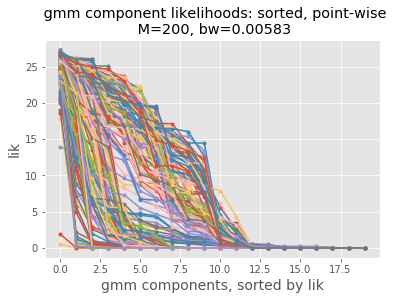

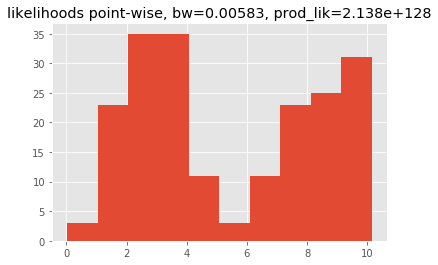

	 prod_liks=2.138e+128,
	 log_prod_liks=2.955e+02,
	 sum_lliks=2.955e+02



-----------------------------



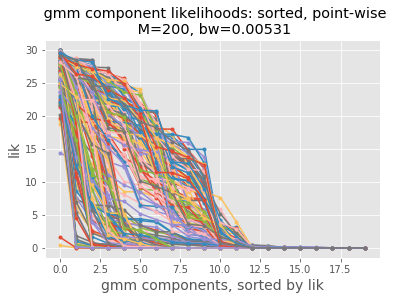

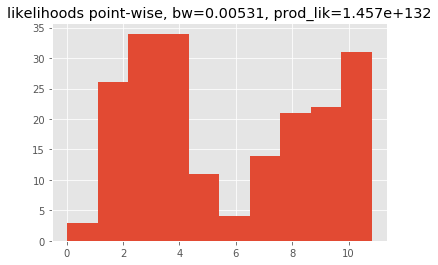

	 prod_liks=1.457e+132,
	 log_prod_liks=3.043e+02,
	 sum_lliks=3.043e+02



-----------------------------



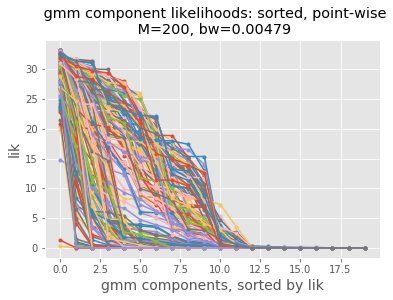

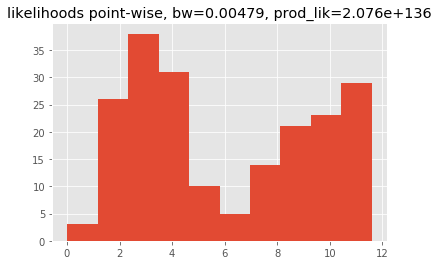

	 prod_liks=2.076e+136,
	 log_prod_liks=3.139e+02,
	 sum_lliks=3.139e+02



-----------------------------



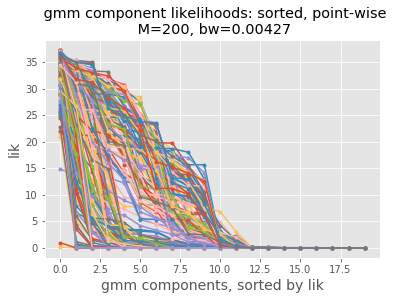

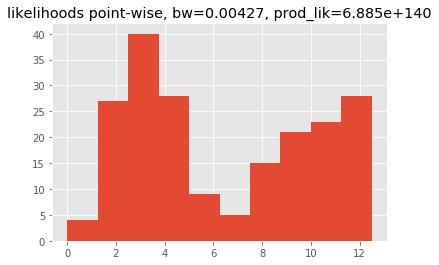

	 prod_liks=6.885e+140,
	 log_prod_liks=3.243e+02,
	 sum_lliks=3.243e+02



-----------------------------



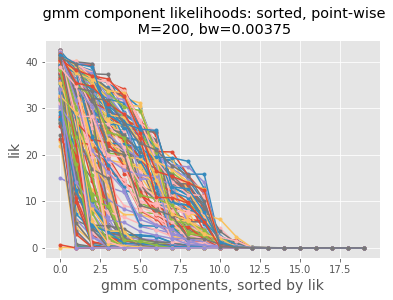

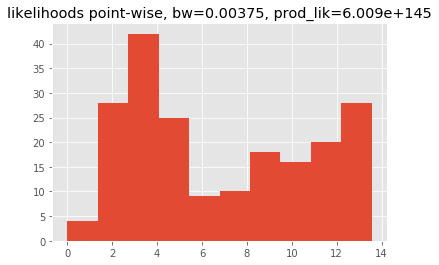

	 prod_liks=6.009e+145,
	 log_prod_liks=3.357e+02,
	 sum_lliks=3.357e+02



-----------------------------



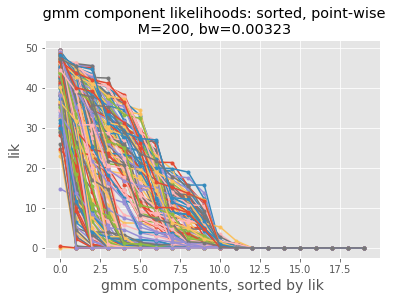

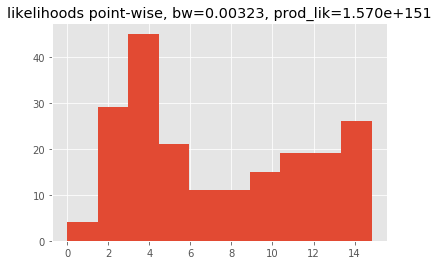

	 prod_liks=1.570e+151,
	 log_prod_liks=3.481e+02,
	 sum_lliks=3.481e+02



-----------------------------



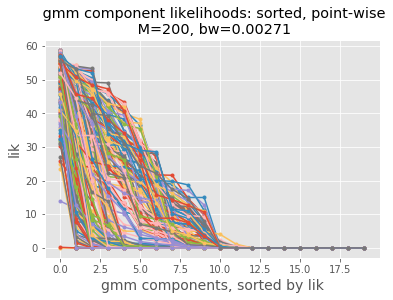

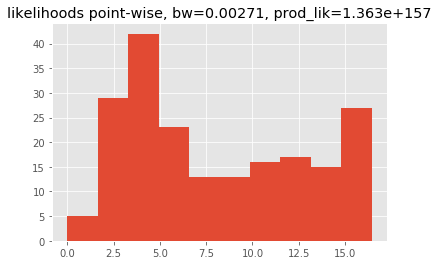

	 prod_liks=1.363e+157,
	 log_prod_liks=3.618e+02,
	 sum_lliks=3.618e+02



-----------------------------



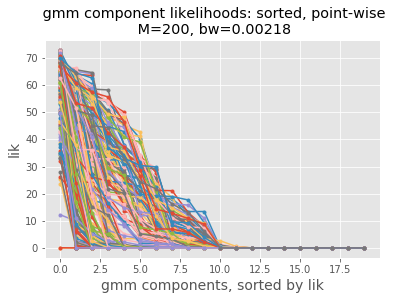

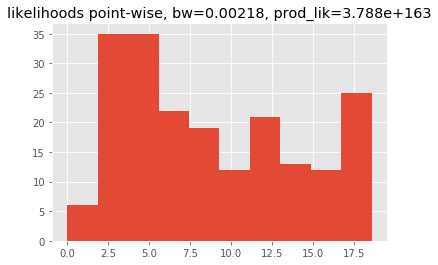

	 prod_liks=3.788e+163,
	 log_prod_liks=3.767e+02,
	 sum_lliks=3.767e+02



-----------------------------



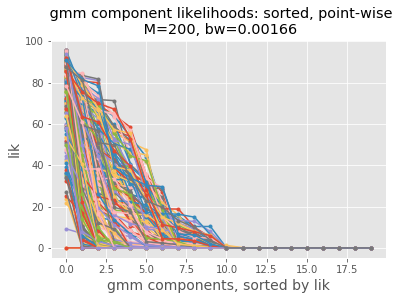

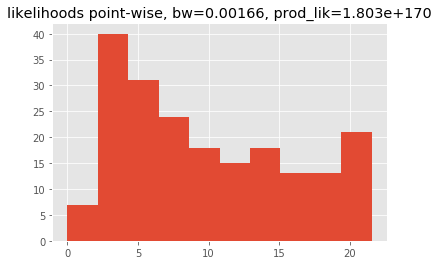

	 prod_liks=1.803e+170,
	 log_prod_liks=3.920e+02,
	 sum_lliks=3.920e+02



-----------------------------



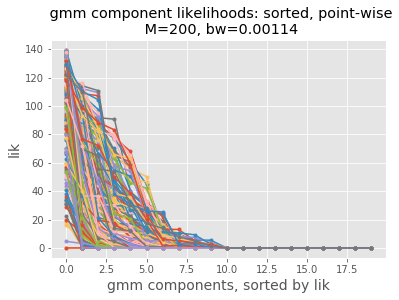

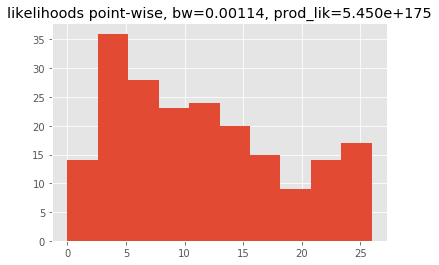

	 prod_liks=5.450e+175,
	 log_prod_liks=4.046e+02,
	 sum_lliks=4.046e+02



-----------------------------



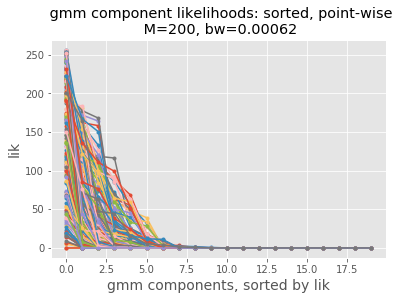

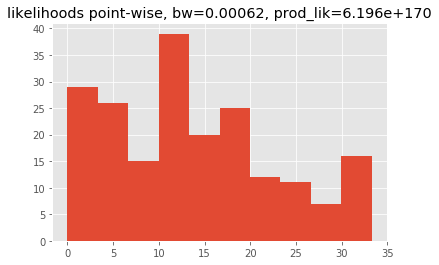

	 prod_liks=6.196e+170,
	 log_prod_liks=3.933e+02,
	 sum_lliks=3.933e+02



-----------------------------



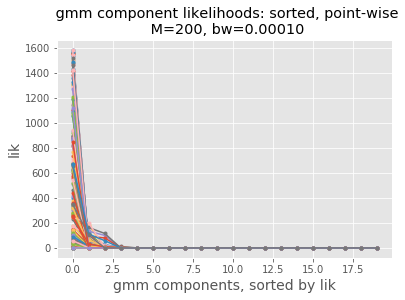

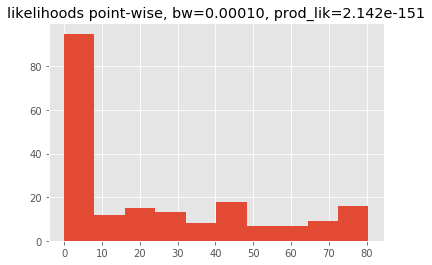

	 prod_liks=2.142e-151,
	 log_prod_liks=-3.469e+02,
	 sum_lliks=-3.469e+02




In [14]:
# Find optimal bandwidth using Maximum Likelihood.
NUM_BANDWIDTHS = 20
BW_HIGH, BW_LOW = 0.01, 0.0001
BW_RANGE = np.linspace(BW_HIGH, BW_LOW, NUM_BANDWIDTHS)
PLOT = 1

# Store bandwidth and likelihood pairs.
bw_lik = np.zeros((NUM_BANDWIDTHS, 2))

# Measure data likelihood under models centered on private support
# points, with a range of bandwidths.
for i, bw in enumerate(BW_RANGE): 
    lik, do_log = mixture_model_likelihood(x, y_tilde, bw)
    
    bw_lik[i] = [bw, lik]


# Print and plot all bandwidth-likelihood pairs.
bw_best, bw_best_lik = bw_lik[np.argmax(bw_lik, axis=0)[1]]
bw_worst, bw_worst_lik = bw_lik[np.argmin(bw_lik, axis=0)[1]]

bw: 0.010000, llik: 2.43e+02
bw: 0.009479, llik: 2.48e+02
bw: 0.008958, llik: 2.54e+02
bw: 0.008437, llik: 2.60e+02
bw: 0.007916, llik: 2.66e+02
bw: 0.007395, llik: 2.73e+02
bw: 0.006874, llik: 2.80e+02
bw: 0.006353, llik: 2.87e+02
bw: 0.005832, llik: 2.95e+02
bw: 0.005311, llik: 3.04e+02
bw: 0.004789, llik: 3.14e+02
bw: 0.004268, llik: 3.24e+02
bw: 0.003747, llik: 3.36e+02
bw: 0.003226, llik: 3.48e+02
bw: 0.002705, llik: 3.62e+02
bw: 0.002184, llik: 3.77e+02
bw: 0.001663, llik: 3.92e+02
bw: 0.001142, llik: 4.05e+02
bw: 0.000621, llik: 3.93e+02
bw: 0.000100, llik: -3.47e+02


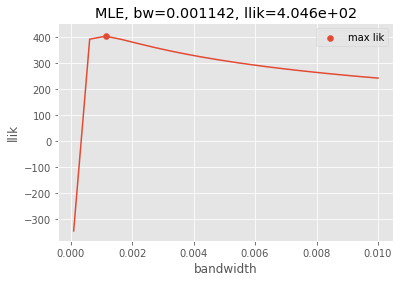

In [15]:
# Plot results for various bandwidths.
lik_str = 'llik' if do_log else 'lik'
for bw, lik in bw_lik:
    print('bw: {:.6f}, {}: {:.2e}'.format(bw, lik_str, lik))
plt.plot(bw_lik[:, 0], bw_lik[:, 1])
plt.scatter(bw_best, bw_best_lik, label='max lik')
plt.xlabel('bandwidth')
plt.ylabel(lik_str)
plt.title('MLE, bw={:.6f}, {}={:.3e}'.format(bw_best, lik_str, bw_best_lik))
plt.legend()
plt.savefig('../output/fig_kde_mle_bw.png')
plt.show()

#### Show samples with best and worst bandwidth.


-----------------------------



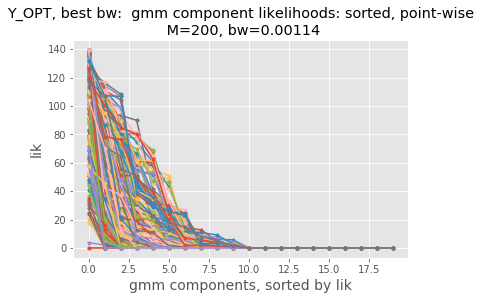

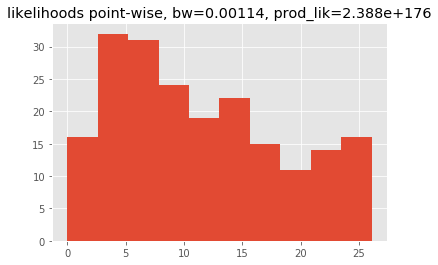

	 prod_liks=2.388e+176,
	 log_prod_liks=4.061e+02,
	 sum_lliks=4.061e+02



-----------------------------



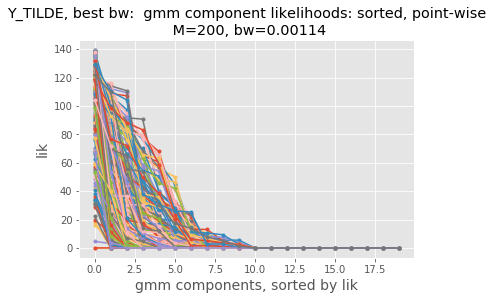

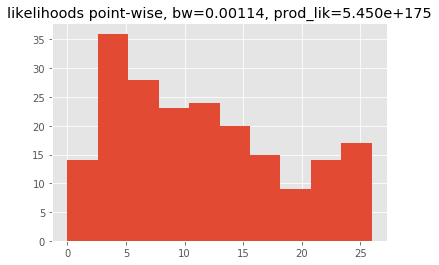

	 prod_liks=5.450e+175,
	 log_prod_liks=4.046e+02,
	 sum_lliks=4.046e+02


do_log: True
P(x | y_opt, bw_best): 4.06e+02
P(x | y_tilde, bw_best): 4.05e+02


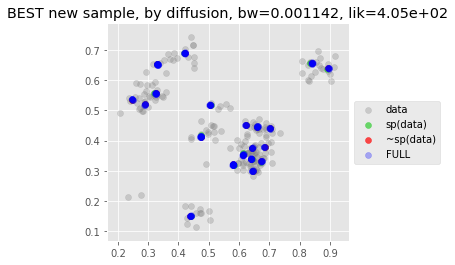

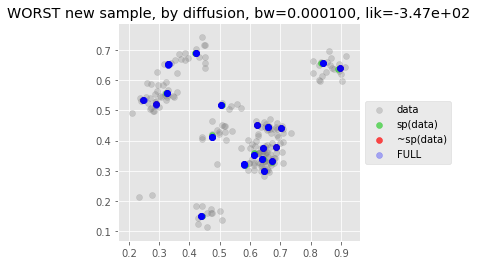

In [16]:
# Compare to likelihoods of data and optimal support points.
lik_y_opt, _ = mixture_model_likelihood(x, y_opt, bw_best,
                                        tag='Y_OPT, best bw: ')
lik_y_tilde, _ = mixture_model_likelihood(x, y_tilde, bw_best,
                                          tag='Y_TILDE, best bw: ')
print('do_log: {}'.format(do_log))
print('P(x | y_opt, bw_best): {:.2e}'.format(lik_y_opt))
print('P(x | y_tilde, bw_best): {:.2e}'.format(lik_y_tilde))


# Plot results.
new_sample_best = (
    y_tilde_upsampled + np.random.normal(0, bw_best,
                                         size=(FULL_SAMPLE_SIZE, x.shape[1])))
new_sample_worst = (
    y_tilde_upsampled + np.random.normal(0, bw_worst,
                                         size=(FULL_SAMPLE_SIZE, x.shape[1])))


if PLOT:
    plt.scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3, label='data')
    plt.scatter(y_opt[:, 0], y_opt[:, 1], c='limegreen', alpha=0.7,
                label='sp(data)')
    plt.scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=0.7,
                label='~sp(data)')
    plt.scatter(new_sample_best[:, 0], new_sample_best[:, 1], c='blue', alpha=0.3,
                label='FULL')

    plt.title('BEST new sample, by {}, bw={:.6f}, lik={:.2e}'.format(
        'diffusion', bw_best, bw_best_lik))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()


    plt.scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3, label='data')
    plt.scatter(y_opt[:, 0], y_opt[:, 1], c='limegreen', alpha=0.7,
                label='sp(data)')
    plt.scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=0.7,
                label='~sp(data)')
    plt.scatter(new_sample_worst[:, 0], new_sample_worst[:, 1], c='blue',
                alpha=0.3, label='FULL')

    plt.title('WORST new sample, by {}, bw={:.6f}, lik={:.2e}'.format(
        'diffusion', bw_worst, bw_worst_lik))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

#### Sample full synthetic set with DP sample of MLE bandwidth.

In this setting, for positive bandwidth $\sigma$, Gaussian data up to $4\sigma$ is bounded on $[0, 1]$ by restricting cluster centers to $[0 + 4\sigma, 1 - 4\sigma]$. The largest $\sigma$ that accommodates this bound is $\sigma = 1/8$. With sensitivity $\Delta f = 1/8$, we sample a DP bandwidth $\tilde{\sigma} \sim \mbox{Lap}(\sigma, \frac{1/8}{\alpha})$, and enforce a non-trivially small positive floor value $\delta$, with $\max(\tilde{\sigma}, \delta)$.


Best bw:       0.001142
raw DP bw:     0.000950
Corrected DP bw: 0.001000

Best bw:       0.001142
raw DP bw:     0.004492
Corrected DP bw: 0.004492

Best bw:       0.001142
raw DP bw:     0.001600
Corrected DP bw: 0.001600

Best bw:       0.001142
raw DP bw:    -0.005043
Corrected DP bw: 0.001000

Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 50.000) = Exp(0.0110)


Exp. mean: 0.01103, e_tilde: 0.00035
  step_size_factor: 0.03146, adjusted: 0.01 -> 0.00031
  Diffusion count    63, e_opt:  0.000901, (e(y, y~) - e~) / e~ = error%: (0.00035 - 0.00035) / 0.00035 = 0.01261

Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 50.000) = Exp(0.0110)


Exp. mean: 0.01103, e_tilde: 0.00035
  step_size_factor: 0.03146, adjusted: 0.01 -> 0.00031
  Diffusion count    63, e_opt:  0.000901, (e(y, y~) - e~) / e~ = error%: (0.00035 - 0.00035) / 0.00035 = 0.01261

Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 50.000) = Exp(0.0110)


Exp

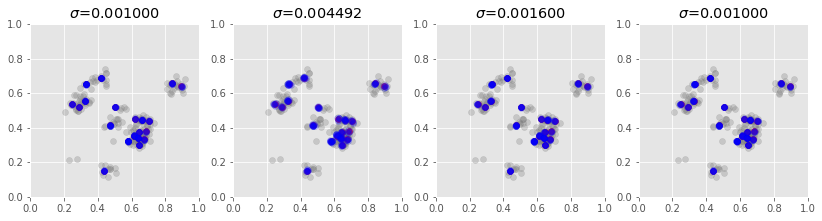

In [17]:
dp_bandwidths = []
floor = 1e-3
n_bw = 4

for _ in range(n_bw):
    dp_bandwidth_raw = bw_best + np.random.laplace(loc=0, scale=(1 / 8) / ALPHA)
    dp_bandwidth = np.max([dp_bandwidth_raw, floor])
    dp_bandwidths.append(dp_bandwidth)
    print('\nBest bw: {:>14.6f}\nraw DP bw: {:>12.6f}\nCorrected DP bw: {:>1.6f}'.format(
            bw_best, dp_bandwidth_raw, dp_bandwidth))



fig, axs = plt.subplots(1, n_bw, figsize=(3 * n_bw, 3))

for i, bw in enumerate(dp_bandwidths):
    np.random.seed(234)
    (y_tilde,
     y_tilde_upsampled,
     y_tilde_expansion) = sample_full_set_by_diffusion(e_opt, energy_sensitivity,
                                                       x, y_opt, STEP_SIZE, ALPHA,
                                                       bw, FULL_SAMPLE_SIZE, 
                                                       plot=False)

    axs[i].set_title(r'$\sigma$={:.6f}'.format(bw))
    axs[i].scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3)
    axs[i].scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=0.7)
    axs[i].scatter(y_tilde_expansion[:, 0], y_tilde_expansion[:, 1],
                   c='blue', alpha=0.2)
    axs[i].set_xlim((0, 1))
    axs[i].set_ylim((0, 1))
        
plt.subplots_adjust(wspace=0.2, hspace=0.2,
                    bottom=0.1, top=0.9, left=0.05, right=0.95)
plt.savefig('../output/fig_kde_dp_mle.png')

# 6.2 KDE with DP median of pairwise distances as bandwidth.

Choose W based on data (median heuristics). Add DP noise to W, i.e. add $\eta \sim \mbox{Lap}(2^{(1/p)} / 2)$. Get SP with MMD_W. Do KDE with W.

In [18]:
if 0:
    # Show data and y_tilde.
    NUM_Y_TILDES = 1
    METHOD = 'diffusion'
    SAMPLE_SIZE = M
    STEP_SIZE = 2e-3

    # Compute median of pairwise distanes, and use that as bandwidth.
    median_pairwise_dists = np.median(pdist(x, 'minkowski', p=ENERGY_POWER))
    sensitivity_median_pairwise_dists = DIM ** (1. / ENERGY_POWER) / 2.
    private_median = median_pairwise_dists + np.random.laplace(
        scale=sensitivity_median_pairwise_dists / ALPHA)
    print(median_pairwise_dists)
    print(private_median)
    #pdb.set_trace()

    """
    (y_tilde,
     y_tilde_upsampled,
     y_tilde_expansion) = sample_full_set_by_diffusion(e_opt, energy_sensitivity,
                                                       x, y_opt, STEP_SIZE, ALPHA,
                                                       private_median, SAMPLE_SIZE)

    plt.scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3, label='data')
    plt.scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=0.7, label='~sp(data)')
    plt.scatter(y_tilde_expansion[:, 0], y_tilde_expansion[:, 1], c='blue', 
                alpha=0.3, label='FULL')

    plt.title('{}, and PRE-SELECTED w = {}'.format(METHOD, BANDWIDTH))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()
    """

## 6.3 Repeated draws of private support points.


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 50.000) = Exp(0.0110)


Exp. mean: 0.01103, e_tilde: 0.01014
  step_size_factor: 0.91909, adjusted: 0.01 -> 0.00919
  Diffusion count    28, e_opt:  0.000901, (e(y, y~) - e~) / e~ = error%: (0.01061 - 0.01014) / 0.01014 = 0.04671

Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 50.000) = Exp(0.0110)


Exp. mean: 0.01103, e_tilde: 0.02711
  step_size_factor: 1.22865, adjusted: 0.01 -> 0.01229
  Diffusion count    86, e_opt:  0.000901, (e(y, y~) - e~) / e~ = error%: (0.02971 - 0.02711) / 0.02711 = 0.09617

Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 50.000) = Exp(0.0110)


Exp. mean: 0.01103, e_tilde: 0.00787
  step_size_factor: 0.71320, adjusted: 0.01 -> 0.00713
  Diffusion count    49, e_opt:  0.000901, (e(y, y~) - e~) / e~ = error%: (0.00882 - 0.00787) / 0.00787 = 0.12153

Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 50.000) = Exp(0.0110)


Ex

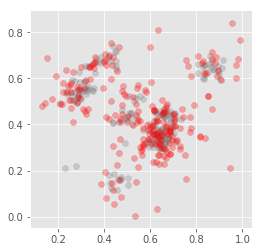

In [19]:
NUM_REPEATS = int(M / N) + 1
new_sample = []
STEP_SIZE = 1e-2
BANDWIDTH = SIGMA_DATA

#print('NOTE: CHANGED ALPHA!')
#ALPHA = NUM_REPEATS * ALPHA

for i in range(NUM_REPEATS):
    (y_tilde,
     y_tilde_upsampled,
     y_tilde_expansion) = sample_full_set_by_diffusion(e_opt, energy_sensitivity,
                                                       x, y_opt, STEP_SIZE,
                                                       ALPHA, BANDWIDTH,
                                                       FULL_SAMPLE_SIZE)
    new_sample.append(y_tilde)


new_sample = np.concatenate(new_sample)

print('\nConcatenating results, and plotting collection of samples as one.\n')
print('{}, alpha={}, repeats={}, budget={},\n n={}, bw={}'.format(
    METHOD, ALPHA, NUM_REPEATS, ALPHA * float(NUM_REPEATS), len(new_sample),
    BANDWIDTH))

plt.scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3, label='data')
# plt.scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=0.7, label='~sp(data)')
plt.scatter(new_sample[:, 0], new_sample[:, 1], c='red', alpha=0.3, label='FULL')
#plt.title('{}, alpha={}, repeats={}, budget={},\n n={}, bw={}'.format(
#    METHOD, ALPHA, NUM_REPEATS, ALPHA * float(NUM_REPEATS), len(new_sample),
#    BANDWIDTH))
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.xlim(0, 1)
#plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.savefig('../output/fig_repeated_samples.png')
plt.show()

# End.